In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import cv2
from ipywidgets import interact, fixed, FloatSlider, IntSlider

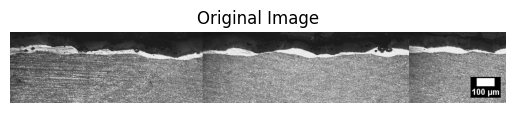

In [2]:
img_path = "src/01.jpg"
pil_img = Image.open(img_path).convert('L')
img_array = np.array(pil_img)

plt.imshow(pil_img, cmap='gray')
plt.axis('off')
plt.title("Original Image")
plt.show()

In [3]:
output = widgets.Output()
scale = None

x1_slider = widgets.IntSlider(value=0, min=0, max=pil_img.width - 1, step=1, description='X1')
y1_slider = widgets.IntSlider(value=0, min=0, max=pil_img.height - 1, step=1, description='Y1')
x2_slider = widgets.IntSlider(value=pil_img.width, min=1, max=pil_img.width, step=1, description='X2')
y2_slider = widgets.IntSlider(value=pil_img.width, min=1, max=pil_img.height, step=1, description='Y2')

def update_crop(x1, y1, x2, y2):
    global scale
    with output:
        output.clear_output(wait=True)
        right = min(x1 + x2, pil_img.width)
        lower = min(y1 + y2, pil_img.height)
        cropped = pil_img.crop((x1, y1, right, lower))
        scale = np.array(cropped)
        plt.imshow(cropped, cmap='gray')
        plt.axis('off')
        plt.title("Cropped Image")
        plt.show()

ui = widgets.VBox([x1_slider, y1_slider, x2_slider, y2_slider])
interactive_out = widgets.interactive_output(update_crop, {
    'x1': x1_slider, 'y1': y1_slider, 'x2': x2_slider, 'y2': y2_slider
})

display(ui, output)

Output()

In [4]:
scale = 150 / scale.shape[1]

In [5]:
output = widgets.Output()
cropped_img = None

x1_slider = widgets.IntSlider(value=0, min=0, max=pil_img.width - 1, description='X1')
y1_slider = widgets.IntSlider(value=0, min=0, max=pil_img.height - 1, description='Y1')
x2_slider = widgets.IntSlider(value=pil_img.width, min=1, max=pil_img.width, description='X2')
y2_slider = widgets.IntSlider(value=pil_img.width, min=1, max=pil_img.height, description='Y2')

def update_crop(x1, y1, x2, y2):
    global cropped_img
    with output:
        output.clear_output(wait=True)
        right = min(x1 + x2, pil_img.width)
        lower = min(y1 + y2, pil_img.height)
        cropped = pil_img.crop((x1, y1, right, lower))
        cropped_img = np.array(cropped)
        plt.imshow(cropped, cmap='gray')
        plt.axis('off')
        plt.title("Cropped Image")
        plt.show()

ui = widgets.VBox([x1_slider, y1_slider, x2_slider, y2_slider])
interactive_out = widgets.interactive_output(update_crop, {
    'x1': x1_slider, 'y1': y1_slider, 'x2': x2_slider, 'y2': y2_slider
})

display(ui, output)

Output()

In [6]:
t_img = None
def thresholding(img_np, lower, upper, ksize):
    global t_img
    _, res = cv2.threshold(cropped_img, lower, upper, cv2.THRESH_BINARY)
    t_img = cv2.medianBlur(res, ksize)
    plt.imshow(t_img, cmap='gray')
    plt.axis('off')
    plt.title("Thresholded Image")
    plt.show()

interact(thresholding,
         img_np=fixed(np.array(pil_img)),  # or your cropped image
         lower=IntSlider(0, 0, 255, 1, description='Lower'),
         upper=IntSlider(255, 0, 255, 1, description='Upper'),
         ksize=IntSlider(1, 1, 15, 2, description='Median ksize'));

interactive(children=(IntSlider(value=0, description='Lower', max=255), IntSlider(value=255, description='Uppe…

In [7]:
final_img = None
def morph_pipeline(img, k1, n1, k2, n2, k3, n3):
    global final_img
    if img is None:
        print("No thresholded image available.")
        return
    
    def apply_morph(img, op, k, n):
        kernel = np.ones((k, k), np.uint8)
        for _ in range(n):
            img = cv2.morphologyEx(img, op, kernel)
        return img

    open1  = apply_morph(img, cv2.MORPH_OPEN,  k1, n1)
    close  = apply_morph(open1, cv2.MORPH_CLOSE, k2, n2)
    open2  = apply_morph(close, cv2.MORPH_OPEN,  k3, n3)
    final_img = open2
    fig, axs = plt.subplots(4, 1, figsize=(14, 4))
    axs[0].imshow(img, cmap='gray'); axs[0].set_title("Input"); axs[0].axis('off')
    axs[1].imshow(open1, cmap='gray'); axs[1].set_title("Opening 1"); axs[1].axis('off')
    axs[2].imshow(close, cmap='gray'); axs[2].set_title("Closing"); axs[2].axis('off')
    axs[3].imshow(open2, cmap='gray'); axs[3].set_title("Opening 2"); axs[3].axis('off')
    plt.tight_layout()
    plt.show()

interact(morph_pipeline,
         img=fixed(t_img),
         k1=IntSlider(3, 1, 15, 1, description="Open1 k"),
         n1=IntSlider(1, 1, 5, 1, description="Layers"),
         k2=IntSlider(5, 1, 15, 1, description="Close k"),
         n2=IntSlider(1, 1, 5, 1, description="Layers"),
         k3=IntSlider(3, 1, 15, 1, description="Open2 k"),
         n3=IntSlider(1, 1, 5, 1, description="Layers"));

interactive(children=(IntSlider(value=3, description='Open1 k', max=15, min=1), IntSlider(value=1, description…

In [8]:
count = 0
sum_  = 0 
final_img = final_img.astype(int)

for col in range(final_img.shape[1]):
    white_found = False
    first = None
    last  = None
    for i in range(final_img.shape[0]):
        if final_img[i, col] == 255 and not white_found:
            white_found = True
            first = i
            last = i
        elif final_img[i, col] == 255:
            last = i
    if white_found:
        sum_ += (last - first)
        count += 1

avg_thickness = sum_ / count if count > 0 else 0
print("Average thickness:", avg_thickness * scale)

Average thickness: 21.305418719211822


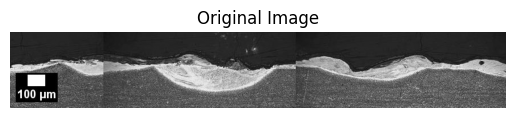

In [9]:
img_path = "src/02.jpg"
pil_img = Image.open(img_path).convert('L')
img_array = np.array(pil_img)

plt.imshow(pil_img, cmap='gray')
plt.axis('off')
plt.title("Original Image")
plt.show()

In [10]:
blurred_img = cv2.medianBlur(img_array, 5)
ret, t_img = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

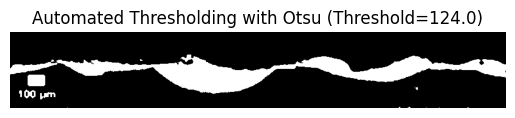

In [11]:
plt.imshow(t_img, cmap='gray')
plt.axis('off')
plt.title(f"Automated Thresholding with Otsu (Threshold={ret})")
plt.show()

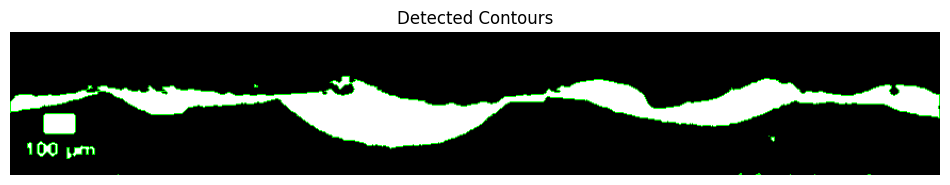

In [12]:
contours, _ = cv2.findContours(t_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Convert your grayscale image to color for better visualization
contour_img = cv2.cvtColor(t_img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_img, contours, -1, (0,255,0), 1)  # green contours, thickness 2
plt.figure(figsize=(12,7))
plt.imshow(contour_img)
plt.axis('off')
plt.title('Detected Contours')
plt.show()

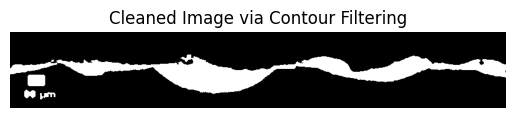

In [13]:
if contours:
    # Calculate the area of all contours
    areas = [cv2.contourArea(c) for c in contours]
    avg_area = sum(areas) / len(areas)

    # Create a new blank image to draw the filtered contours on
    final_img = np.zeros_like(t_img)

    # Keep only the contours that are reasonably large (e.g., > 10% of the average area)
    # This threshold can be tuned or determined from the data distribution.
    area_threshold = 0.1 * avg_area
    good_contours = [c for c in contours if cv2.contourArea(c) > area_threshold]

    # Draw the "good" contours onto the blank image, filling them in
    cv2.drawContours(final_img, good_contours, -1, (255, 255, 255), thickness=cv2.FILLED)

    plt.imshow(final_img, cmap='gray')
    plt.axis('off')
    plt.title("Cleaned Image via Contour Filtering")
    plt.show()

else:
    print("No contours found.")
    final_img = t_img # Fallback to the thresholded image if no contours are found

In [16]:
def show(img):
    plt.figure(figsize=(15, 8))
    plt.imshow(img, cmap="gray")
    return

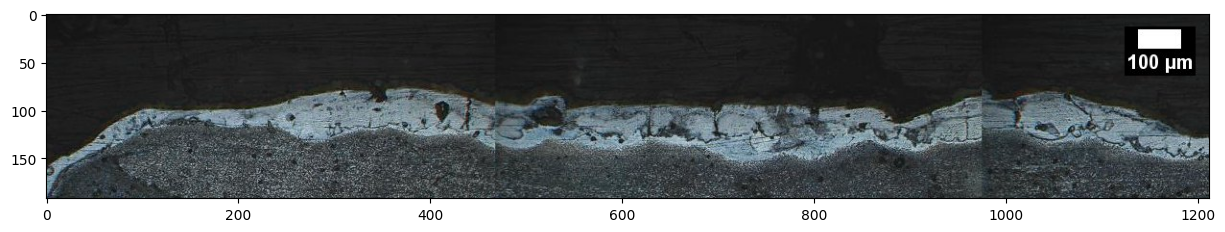

In [27]:
img = cv2.imread("src/03.jpg")
show(img)

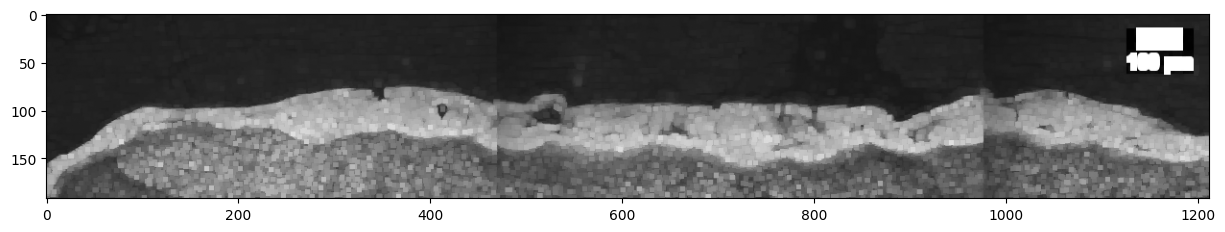

In [22]:
max_filtered_img = cv2.dilate(img, np.ones((5, 5), np.uint8), iterations=1)
show(max_filtered_img)

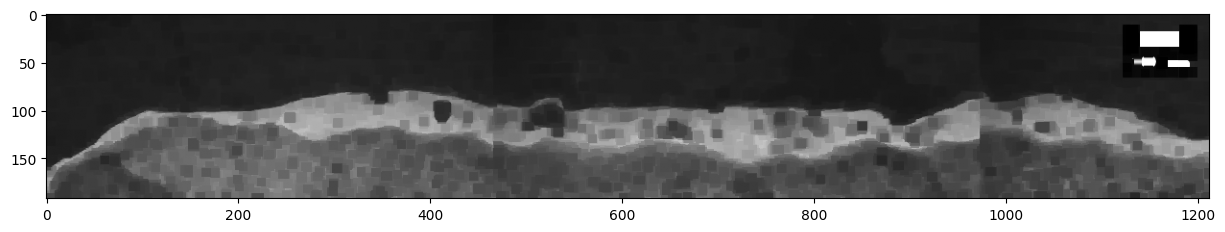

In [24]:
min_filtered_img = cv2.erode(max_filtered_img, np.ones((5, 5), np.uint8), iterations=2)
show(min_filtered_img)

In [28]:
gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [29]:
plt.imsave("03.png", gimg)